In [1]:
import numpy as np
import awkward
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import pandas as pd

Using TensorFlow backend.


In [4]:
##========================================================data by pythia

_e,_pt,_eta,_phi,_logpt,_loge=0,1,2,3,4,5 ## choose the index you save (same as 2PCNN loading data part)

def deltaPhi(phi1,phi2):
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

def deltaR(eta1,phi1,eta2,phi2):
    return (deltaPhi(phi1,phi2)**2+(eta1-eta2)**2)**0.5

def find_main_axis(clist):
    def fcn(p):
        dir_x,dir_y = np.cos(p[0]),np.sin(p[0])
        v = clist[(clist[:,_eta]**2+clist[:,_phi]**2)**0.5>1E-5]
        cosang = np.abs(dir_x*v[:,_eta]+dir_y*v[:,_phi])/(v[:,_eta]**2+v[:,_phi]**2)**0.5
        proj = (v[:,_pt]*cosang).sum()
        return -proj
    r = opt.minimize(fcn,[0.])
    if r.success: return r.x[0]
    else: return None
def parse_jet_data(fin):
    
    
#     if '<jet_data>' not in fin.readline().decode():
#         print(">>> ERROR: invalid input", flush=True)
#         sys.exit(0)
    
    data = {}
#     features_list = {}
    fin.readline().decode().split()
    buf = fin.readline().decode().split() # jet kinematics
    data['e'] = float(buf[0])
    data['pt'] = float(buf[1])
    data['eta'] = float(buf[2])
    data['phi'] = float(buf[3])
    data['nconstituents'] = int(buf[4])
    fin.readline().decode().split()
    clist, mask, features, points = [],np.zeros((100,1)), np.zeros((100,5)), np.zeros((100,2)) # prepare constituents list
    if (data['nconstituents']<=100):
        for i in range(data['nconstituents']):  ##particlenet need to be 100
            #         _pt,_eta,_phi=1,2,3 #myfile use pt in index 1, eta->2,phi->3
            var = [float(s) for s in fin.readline().decode().split()] # index, type(0:gen/1:track/2:Ecal/3:Hcal), pid, charge, pt, eta, phi, vx, vy, vz
            var_logpt = np.log(var[_pt])
            var_loge = np.log(var[_e])
            var[_eta] = var[_eta]-data['eta']
            var[_phi] = deltaPhi(var[_phi],data['phi'])
            mask[i]=np.array([var_logpt])
            features[i]=np.array([var_logpt,var_loge,var[_eta],var[_phi], var[_pt]/data['pt']] ) #last one is my argue
            points[i]=np.array([var[_eta],var[_phi] ])#, var[_pt]/data['pt']])
    else:
        for i in range(data['nconstituents']):
            fin.readline().decode().split()
       

#     clist = np.array(clist)
#     features_list['mask']=np.array(mask)
#     features_list['points']=np.array(points)
#     features_list['features']=np.array(features)
#     dir = find_main_axis(clist) ##rotation
#     if dir!=None:
#         dir = -dir # rotation everything to x-axis
#         clist[:,_eta], clist[:,_phi] = np.cos(dir)*clist[:,_eta]-np.sin(dir)*clist[:,_phi], np.sin(dir)*clist[:,_eta]+np.cos(dir)*clist[:,_phi]

    
    return mask.tolist(), features.tolist(), points.tolist()
def prepare(n,fin):
    fin=gzip.open(fin)
    features_list = {}
    mask, features, points = [],[],[]
    for i in range(n):
        a, b, c = parse_jet_data(fin)
        mask.append(a)
        features.append(b)
        points.append(c)

    features_list['mask']=mask
    features_list['points']=points
    features_list['features']=features
    return features_list
    
def separatedata(features_list,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = features_list["mask"]
    features = features_list["features"]
    points = features_list["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test) 
def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total
def input_trans( X_test, y_test):
    features_test = {}
    
    features_test['mask']=np.array([i for i in X_test["mask"]])
    features_test['features']=np.array([i for i in X_test["features"]])
    features_test['points']=np.array([i for i in X_test["points"]])
    return features_test, np.array(y_test) 

In [5]:
## load data
eventg, eventq = './myeventsgg2.txt.gz', './myeventsqq2.txt.gz'
n=50000
gg = prepare(n,eventg)
n=24000
qq1 = prepare(n,eventq)
eventq = './myeventsqq1.txt.gz'
n=26000
qq2 = prepare(n,eventq)
qq = merging(qq2,qq1)

y=[[0,1] for i in range(len(gg['mask']))]+[[1,0] for i in range(len(qq['mask']))] ##?????????????????
total = merging(gg,qq)

# del gg, qq, eventg, eventq
del gg, qq, eventg, eventq, qq1, qq2

X_train, X_val, X_test, y_train, y_val, y_test = separatedata(total,y,0.3,0.1)

In [19]:
## if you want to use same test data with 2PCNN
eventg, eventq = './myeventsgg3.txt.gz', './myeventsqq3.txt.gz'
n=5000
gg = prepare(n,eventg)
qq = prepare(n,eventq)
y=[[0,1] for i in range(len(gg['mask']))]+[[1,0] for i in range(len(qq['mask']))] ##?????????????????
total = merging(gg,qq)
X_test, y_test = input_trans(total,y)

In [1]:


import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [2]:
##self

model_type = 'particle_net'
input_shapes={'points': (100, 2), 'features': (100, 5), 'mask': (100, 1)}
num_classes = 2
w =  -1 ## weights you can choose (it is added by myself, and I use the 5-th as the weight term)
model = get_particle_net(num_classes, input_shapes, w=w)

In [27]:
# Training parameters
batch_size = 64 if 'lite' in model_type else 64
epochs = 30

In [28]:
# def lr_schedule(epoch):
#     lr = 1e-3
#     if epoch > 10:
#         lr *= 0.1
#     elif epoch > 20:
#         lr *= 0.01
#     logging.info('Learning rate: %f'%lr)
#     return lr
def lr_schedule(epoch):
    lr = 2e-1
    n = 3
    if epoch > 4:
        lr *= 1/n
    if epoch > 9:
        lr *= 1/n
    if epoch > 16:
        lr *= 1/n
    if epoch > 21:
        lr *= 1/n
    if epoch > 26:
        lr *= 1/n
    if epoch > 31:
        lr *= 1/n
    if epoch > 36:
        lr *= 1/n
    if epoch > 41:
        lr *= 1/n
    logging.info('Learning rate: %f'%lr)
    return lr

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2020-04-04 10:13:29,732] INFO: Learning rate: 0.200000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 100, 5)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 100, 1, 5)]  0           features[0][0]                   
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
ParticleNet_fts_bn (BatchNormal (None, 100, 1, 5)    20          tf_op_layer_ExpandDims[0][0]     
________________________________________________________________________________________

In [11]:
# load model
model.load_weights('./my_ParticleNet.h5')

ValueError: Shapes (5,) and (4,) are incompatible

In [30]:
# Prepare model model saving directory.
import os
save_dir = './model_checkpoints'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
csv_logger = keras.callbacks.CSVLogger('./myparticlenet_training_log.csv')
earlystop = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0,
                            patience=50,
                            verbose=1,
                            mode='min', baseline=None,
                            restore_best_weights=True)
# callbacks = [checkpoint, lr_scheduler, progress_bar]
callbacks = [checkpoint, lr_scheduler, csv_logger, progress_bar, earlystop ]
### Add checkpoints
##########################################################################################################
# check_list=[]
# checkpoint = tf.keras.callbacks.ModelCheckpoint (monitor='val_loss',
#                              filepath='./mymodel.h5',
#                              save_best_only=True,
#                              verbose=1)
# earlystop = tf.keras.callbacks.EarlyStopping(
#                             monitor='val_loss',
#                             min_delta=0,
#                             patience=50,
#                             verbose=1,
#                             mode='min', baseline=None,
#                             restore_best_weights=True)

# csv_logger = tf.keras.callbacks.CSVLogger('./training_log.csv')
# check_list.append(checkpoint)
# check_list.append(earlystop)
# check_list.append(csv_logger)
##########################################################################################################

In [31]:
# train_dataset.shuffle()
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs, # --- train only for 1 epoch here for demonstration ---
          validation_data=(X_val, y_val),
          shuffle=True ,
          callbacks=callbacks)
model.evaluate(X_test,  y_test, verbose=2)

[2020-04-04 10:13:35,546] INFO: Learning rate: 0.200000


Train on 60000 samples, validate on 30000 samples
Epoch 1/60
Epoch 1/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5381 - accuracy: 0.7511WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:15:00,223] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 85s 1ms/sample - loss: 0.5381 - accuracy: 0.7511 - val_loss: 0.4873 - val_accuracy: 0.7895


[2020-04-04 10:15:00,277] INFO: Learning rate: 0.200000


Epoch 2/60
Epoch 2/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5422 - accuracy: 0.7473WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:16:20,090] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5421 - accuracy: 0.7473 - val_loss: 0.4774 - val_accuracy: 0.7919


[2020-04-04 10:16:20,144] INFO: Learning rate: 0.200000


Epoch 3/60
Epoch 3/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5263 - accuracy: 0.7596WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:17:39,979] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5263 - accuracy: 0.7597 - val_loss: 0.4777 - val_accuracy: 0.7855


[2020-04-04 10:17:39,985] INFO: Learning rate: 0.200000


Epoch 4/60
Epoch 4/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5319 - accuracy: 0.7559WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:18:59,744] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5319 - accuracy: 0.7559 - val_loss: 0.4799 - val_accuracy: 0.7909


[2020-04-04 10:18:59,750] INFO: Learning rate: 0.200000


Epoch 5/60
Epoch 5/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5363 - accuracy: 0.7528WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:20:19,629] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5363 - accuracy: 0.7528 - val_loss: 0.6261 - val_accuracy: 0.7343


[2020-04-04 10:20:19,635] INFO: Learning rate: 0.066667


Epoch 6/60
Epoch 6/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5159 - accuracy: 0.7670WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:21:40,799] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 81s 1ms/sample - loss: 0.5158 - accuracy: 0.7671 - val_loss: 0.4603 - val_accuracy: 0.8041


[2020-04-04 10:21:40,865] INFO: Learning rate: 0.066667


Epoch 7/60
Epoch 7/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5152 - accuracy: 0.7675WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:23:01,021] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5151 - accuracy: 0.7676 - val_loss: 0.4642 - val_accuracy: 0.8002


[2020-04-04 10:23:01,027] INFO: Learning rate: 0.066667


Epoch 8/60
Epoch 8/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5101 - accuracy: 0.7708WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:24:20,880] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5102 - accuracy: 0.7707 - val_loss: 0.4530 - val_accuracy: 0.8032


[2020-04-04 10:24:20,935] INFO: Learning rate: 0.066667


Epoch 9/60
Epoch 9/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5108 - accuracy: 0.7705WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:25:41,036] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5109 - accuracy: 0.7705 - val_loss: 0.4640 - val_accuracy: 0.8029


[2020-04-04 10:25:41,042] INFO: Learning rate: 0.066667


Epoch 10/60
Epoch 10/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5096 - accuracy: 0.7711WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:27:00,693] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5097 - accuracy: 0.7710 - val_loss: 0.4592 - val_accuracy: 0.8037


[2020-04-04 10:27:00,700] INFO: Learning rate: 0.022222


Epoch 11/60
Epoch 11/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5011 - accuracy: 0.7765WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:28:19,842] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 79s 1ms/sample - loss: 0.5011 - accuracy: 0.7765 - val_loss: 0.4588 - val_accuracy: 0.8044


[2020-04-04 10:28:19,849] INFO: Learning rate: 0.022222


Epoch 12/60
Epoch 12/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.7773WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:29:39,371] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5013 - accuracy: 0.7774 - val_loss: 0.4584 - val_accuracy: 0.8064


[2020-04-04 10:29:39,377] INFO: Learning rate: 0.022222


Epoch 13/60
Epoch 13/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5031 - accuracy: 0.7742WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:30:59,550] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5032 - accuracy: 0.7741 - val_loss: 0.4569 - val_accuracy: 0.8060


[2020-04-04 10:30:59,556] INFO: Learning rate: 0.022222


Epoch 14/60
Epoch 14/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5019 - accuracy: 0.7766WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:32:19,359] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5019 - accuracy: 0.7766 - val_loss: 0.4563 - val_accuracy: 0.8058


[2020-04-04 10:32:19,365] INFO: Learning rate: 0.022222


Epoch 15/60
Epoch 15/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5006 - accuracy: 0.7763WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:33:39,274] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5005 - accuracy: 0.7764 - val_loss: 0.4568 - val_accuracy: 0.8046


[2020-04-04 10:33:39,280] INFO: Learning rate: 0.022222


Epoch 16/60
Epoch 16/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.5027 - accuracy: 0.7757WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:34:59,375] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5027 - accuracy: 0.7757 - val_loss: 0.4617 - val_accuracy: 0.8052


[2020-04-04 10:34:59,381] INFO: Learning rate: 0.022222


Epoch 17/60
Epoch 17/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4995 - accuracy: 0.7786WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:36:18,807] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 79s 1ms/sample - loss: 0.4994 - accuracy: 0.7786 - val_loss: 0.4610 - val_accuracy: 0.7975


[2020-04-04 10:36:18,814] INFO: Learning rate: 0.007407


Epoch 18/60
Epoch 18/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4965 - accuracy: 0.7792WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:37:38,636] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4965 - accuracy: 0.7792 - val_loss: 0.4609 - val_accuracy: 0.8051


[2020-04-04 10:37:38,642] INFO: Learning rate: 0.007407


Epoch 19/60
Epoch 19/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4934 - accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:38:57,920] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 79s 1ms/sample - loss: 0.4934 - accuracy: 0.7814 - val_loss: 0.4576 - val_accuracy: 0.8010


[2020-04-04 10:38:57,926] INFO: Learning rate: 0.007407


Epoch 20/60
Epoch 20/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.7780WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:40:18,086] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4997 - accuracy: 0.7781 - val_loss: 0.4520 - val_accuracy: 0.8082


[2020-04-04 10:40:18,139] INFO: Learning rate: 0.007407


Epoch 21/60
Epoch 21/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4980 - accuracy: 0.7803WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:41:38,197] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4980 - accuracy: 0.7803 - val_loss: 0.4546 - val_accuracy: 0.8082


[2020-04-04 10:41:38,203] INFO: Learning rate: 0.007407


Epoch 22/60
Epoch 22/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4951 - accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:42:58,005] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4951 - accuracy: 0.7814 - val_loss: 0.4609 - val_accuracy: 0.8016


[2020-04-04 10:42:58,011] INFO: Learning rate: 0.002469


Epoch 23/60
Epoch 23/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4948 - accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:44:18,161] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4949 - accuracy: 0.7813 - val_loss: 0.4572 - val_accuracy: 0.8058


[2020-04-04 10:44:18,169] INFO: Learning rate: 0.002469


Epoch 24/60
Epoch 24/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4957 - accuracy: 0.7813WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:45:38,350] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4956 - accuracy: 0.7814 - val_loss: 0.4565 - val_accuracy: 0.8070


[2020-04-04 10:45:38,356] INFO: Learning rate: 0.002469


Epoch 25/60
Epoch 25/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4958 - accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:46:58,671] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4958 - accuracy: 0.7807 - val_loss: 0.4553 - val_accuracy: 0.8078


[2020-04-04 10:46:58,677] INFO: Learning rate: 0.002469


Epoch 26/60
Epoch 26/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4935 - accuracy: 0.7821WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:48:18,530] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4935 - accuracy: 0.7821 - val_loss: 0.4520 - val_accuracy: 0.8081


[2020-04-04 10:48:18,536] INFO: Learning rate: 0.002469


Epoch 27/60
Epoch 27/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4947 - accuracy: 0.7805WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:49:38,414] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4946 - accuracy: 0.7805 - val_loss: 0.4535 - val_accuracy: 0.8095


[2020-04-04 10:49:38,420] INFO: Learning rate: 0.000823


Epoch 28/60
Epoch 28/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4959 - accuracy: 0.7801WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:50:58,129] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4959 - accuracy: 0.7801 - val_loss: 0.4539 - val_accuracy: 0.8083


[2020-04-04 10:50:58,135] INFO: Learning rate: 0.000823


Epoch 29/60
Epoch 29/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4930 - accuracy: 0.7821WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:52:18,028] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4930 - accuracy: 0.7822 - val_loss: 0.4527 - val_accuracy: 0.8088


[2020-04-04 10:52:18,034] INFO: Learning rate: 0.000823


Epoch 30/60
Epoch 30/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:53:37,891] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4949 - accuracy: 0.7814 - val_loss: 0.4536 - val_accuracy: 0.8085


[2020-04-04 10:53:37,899] INFO: Learning rate: 0.000823


Epoch 31/60
Epoch 31/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:54:57,498] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4949 - accuracy: 0.7812 - val_loss: 0.4542 - val_accuracy: 0.8082


[2020-04-04 10:54:57,505] INFO: Learning rate: 0.000823


Epoch 32/60
Epoch 32/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4917 - accuracy: 0.7828WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:56:17,514] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4917 - accuracy: 0.7828 - val_loss: 0.4534 - val_accuracy: 0.8086


[2020-04-04 10:56:17,519] INFO: Learning rate: 0.000274


Epoch 33/60
Epoch 33/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 0.7830WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:57:37,166] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4929 - accuracy: 0.7830 - val_loss: 0.4545 - val_accuracy: 0.8074


[2020-04-04 10:57:37,173] INFO: Learning rate: 0.000274


Epoch 34/60
Epoch 34/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4951 - accuracy: 0.7808WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 10:58:57,124] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4951 - accuracy: 0.7809 - val_loss: 0.4536 - val_accuracy: 0.8083


[2020-04-04 10:58:57,131] INFO: Learning rate: 0.000274


Epoch 35/60
Epoch 35/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4951 - accuracy: 0.7799WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:00:17,794] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 81s 1ms/sample - loss: 0.4951 - accuracy: 0.7799 - val_loss: 0.4536 - val_accuracy: 0.8078


[2020-04-04 11:00:17,800] INFO: Learning rate: 0.000274


Epoch 36/60
Epoch 36/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4936 - accuracy: 0.7821WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:01:38,532] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 81s 1ms/sample - loss: 0.4936 - accuracy: 0.7821 - val_loss: 0.4540 - val_accuracy: 0.8081


[2020-04-04 11:01:38,538] INFO: Learning rate: 0.000274


Epoch 37/60
Epoch 37/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 0.7818WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:02:59,195] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 81s 1ms/sample - loss: 0.4929 - accuracy: 0.7818 - val_loss: 0.4537 - val_accuracy: 0.8088


[2020-04-04 11:02:59,202] INFO: Learning rate: 0.000091


Epoch 38/60
Epoch 38/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4964 - accuracy: 0.7815WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:04:19,468] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4963 - accuracy: 0.7815 - val_loss: 0.4542 - val_accuracy: 0.8072


[2020-04-04 11:04:19,474] INFO: Learning rate: 0.000091


Epoch 39/60
Epoch 39/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4942 - accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:05:39,486] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4942 - accuracy: 0.7814 - val_loss: 0.4540 - val_accuracy: 0.8077


[2020-04-04 11:05:39,493] INFO: Learning rate: 0.000091


Epoch 40/60
Epoch 40/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4951 - accuracy: 0.7798WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:06:59,913] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4951 - accuracy: 0.7799 - val_loss: 0.4541 - val_accuracy: 0.8086


[2020-04-04 11:06:59,919] INFO: Learning rate: 0.000091


Epoch 41/60
Epoch 41/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4960 - accuracy: 0.7802WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:08:20,050] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4959 - accuracy: 0.7802 - val_loss: 0.4545 - val_accuracy: 0.8072


[2020-04-04 11:08:20,056] INFO: Learning rate: 0.000091


Epoch 42/60
Epoch 42/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4940 - accuracy: 0.7822WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:09:40,095] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4940 - accuracy: 0.7821 - val_loss: 0.4538 - val_accuracy: 0.8080


[2020-04-04 11:09:40,101] INFO: Learning rate: 0.000030


Epoch 43/60
Epoch 43/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4949 - accuracy: 0.7804WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:11:00,189] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4950 - accuracy: 0.7804 - val_loss: 0.4549 - val_accuracy: 0.8078


[2020-04-04 11:11:00,196] INFO: Learning rate: 0.000030


Epoch 44/60
Epoch 44/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4940 - accuracy: 0.7815WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:12:20,620] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4939 - accuracy: 0.7816 - val_loss: 0.4543 - val_accuracy: 0.8079


[2020-04-04 11:12:20,626] INFO: Learning rate: 0.000030


Epoch 45/60
Epoch 45/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4925 - accuracy: 0.7825WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:13:40,507] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4925 - accuracy: 0.7825 - val_loss: 0.4536 - val_accuracy: 0.8078


[2020-04-04 11:13:40,513] INFO: Learning rate: 0.000030


Epoch 46/60
Epoch 46/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4913 - accuracy: 0.7824WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:15:00,552] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4913 - accuracy: 0.7824 - val_loss: 0.4542 - val_accuracy: 0.8068


[2020-04-04 11:15:00,557] INFO: Learning rate: 0.000030


Epoch 47/60
Epoch 47/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4939 - accuracy: 0.7811WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:16:20,048] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 79s 1ms/sample - loss: 0.4939 - accuracy: 0.7811 - val_loss: 0.4540 - val_accuracy: 0.8078


[2020-04-04 11:16:20,055] INFO: Learning rate: 0.000030


Epoch 48/60
Epoch 48/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4942 - accuracy: 0.7819WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:17:39,978] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4943 - accuracy: 0.7818 - val_loss: 0.4541 - val_accuracy: 0.8081


[2020-04-04 11:17:39,984] INFO: Learning rate: 0.000030


Epoch 49/60
Epoch 49/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4938 - accuracy: 0.7806WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:18:59,904] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4937 - accuracy: 0.7807 - val_loss: 0.4539 - val_accuracy: 0.8080


[2020-04-04 11:18:59,911] INFO: Learning rate: 0.000030


Epoch 50/60
Epoch 50/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.7807WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:20:19,739] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4952 - accuracy: 0.7806 - val_loss: 0.4541 - val_accuracy: 0.8084


[2020-04-04 11:20:19,745] INFO: Learning rate: 0.000030


Epoch 51/60
Epoch 51/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4913 - accuracy: 0.7839WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:21:39,674] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4912 - accuracy: 0.7839 - val_loss: 0.4546 - val_accuracy: 0.8082


[2020-04-04 11:21:39,680] INFO: Learning rate: 0.000030


Epoch 52/60
Epoch 52/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4943 - accuracy: 0.7813WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:22:59,589] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4943 - accuracy: 0.7814 - val_loss: 0.4544 - val_accuracy: 0.8073


[2020-04-04 11:22:59,595] INFO: Learning rate: 0.000030


Epoch 53/60
Epoch 53/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4941 - accuracy: 0.7811WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:24:19,810] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4940 - accuracy: 0.7812 - val_loss: 0.4546 - val_accuracy: 0.8070


[2020-04-04 11:24:19,816] INFO: Learning rate: 0.000030


Epoch 54/60
Epoch 54/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4916 - accuracy: 0.7835WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:25:39,623] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4916 - accuracy: 0.7835 - val_loss: 0.4539 - val_accuracy: 0.8078


[2020-04-04 11:25:39,629] INFO: Learning rate: 0.000030


Epoch 55/60
Epoch 55/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4941 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:26:58,917] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 79s 1ms/sample - loss: 0.4941 - accuracy: 0.7813 - val_loss: 0.4541 - val_accuracy: 0.8084


[2020-04-04 11:26:58,923] INFO: Learning rate: 0.000030


Epoch 56/60
Epoch 56/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4952 - accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:28:18,576] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4951 - accuracy: 0.7814 - val_loss: 0.4540 - val_accuracy: 0.8085


[2020-04-04 11:28:18,582] INFO: Learning rate: 0.000030


Epoch 57/60
Epoch 57/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4933 - accuracy: 0.7830WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:29:38,628] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4934 - accuracy: 0.7829 - val_loss: 0.4543 - val_accuracy: 0.8079


[2020-04-04 11:29:38,634] INFO: Learning rate: 0.000030


Epoch 58/60
Epoch 58/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4949 - accuracy: 0.7804WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:30:58,339] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4949 - accuracy: 0.7803 - val_loss: 0.4536 - val_accuracy: 0.8083


[2020-04-04 11:30:58,345] INFO: Learning rate: 0.000030


Epoch 59/60
Epoch 59/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4927 - accuracy: 0.7823WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:32:18,007] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4926 - accuracy: 0.7823 - val_loss: 0.4543 - val_accuracy: 0.8078


[2020-04-04 11:32:18,014] INFO: Learning rate: 0.000030


Epoch 60/60
Epoch 60/60
59968/60000 [============================>.] - ETA: 0s - loss: 0.4936 - accuracy: 0.7822WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2020-04-04 11:33:38,346] WARNING: Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 80s 1ms/sample - loss: 0.4935 - accuracy: 0.7822 - val_loss: 0.4540 - val_accuracy: 0.8080
10000/1 - 11s - loss: 0.5198 - accuracy: 0.8039


[0.45994441299438477, 0.8039]

In [32]:
model.save('./my_ParticleNet.h5')

In [33]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle

The area under the curves are:
AUC:0.876032040


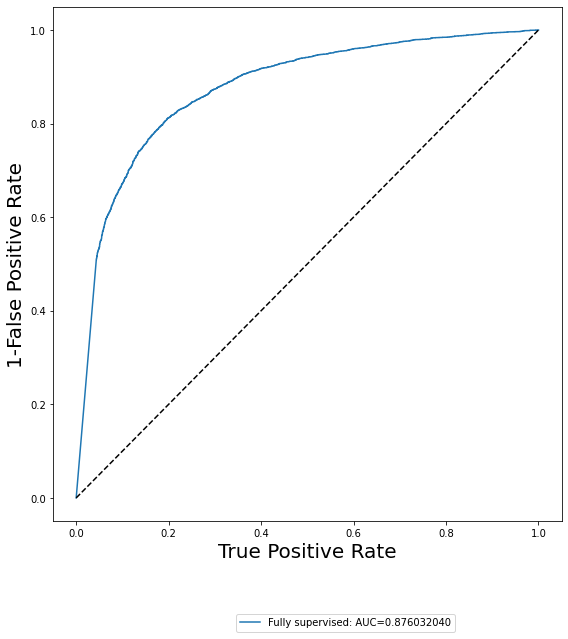

In [34]:
# y_test=[i[1] for i in testpojen_datay]
y_score=model.predict(X_test)[:,0]
test=[i[1] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./Myneighnorhood_Particlenet_roc.png")
np.save("./myfpr",fpr)
np.save("./mytpr",tpr)
#plt.close()

# plt.subplot(2,1,2)
# LOSS = pd.read_csv('./training_log.csv')
# plt.plot(LOSS["loss"], label='loss',c='blue')
# plt.plot(LOSS["val_loss"], label='val_loss',c='red')
# plt.ylabel('loss',fontsize=20)
# plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
# plt.tight_layout()

#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

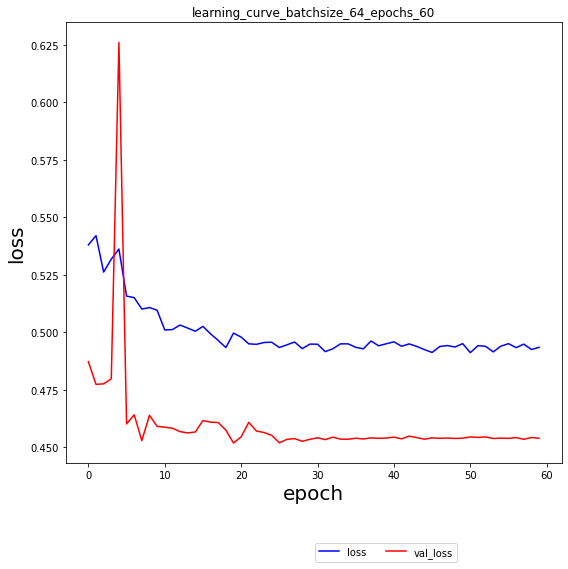

In [35]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv('./myparticlenet_training_log.csv')
plt.title("learning_curve_batchsize_"+str(batch_size)+"_epochs_"+str(epochs))
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./myloss.png")
#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

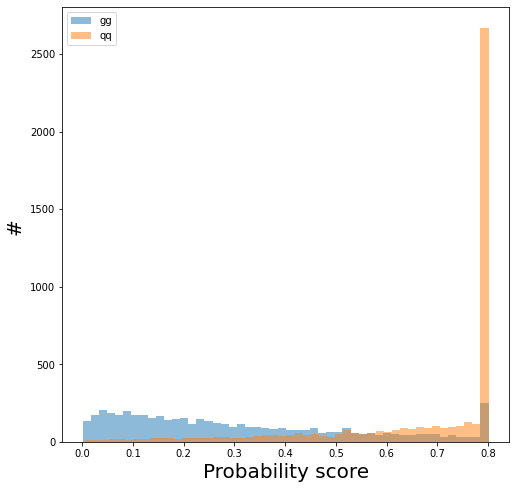

In [37]:
plt.figure(figsize=(8,8))
x=[y_score[i] for i in range(len(y_score)) if y_test[i][1]!=0 ]
y=[y_score[i] for i in range(len(y_score)) if y_test[i][1]!=1 ]
plt.hist(x, label='gg',bins=50,alpha=0.5)
plt.hist(y, label='qq',bins=50,alpha=0.5)
plt.ylabel('# ',fontsize=20)
plt.xlabel('Probability score',fontsize=20)
plt.legend()
plt.savefig("./Myneighnorhood_Particlenet_Prob.png")
np.save("./mygg",x)
np.save("./myqq",y)